In [277]:
%matplotlib inline

In [278]:
import matplotlib.pyplot as plt
import math
import numpy as np

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

# Generating Parameters

In [279]:
with open('/home/taylor/Documents/independent-research/event-gen/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']

gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 10

In [280]:
#Generator Python object
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [281]:
#for params in pgen:
#    print(params)

In [282]:
# of the form ([x0, y0, z0, enu0, azi0, pol0], [beam vector (3d)])
p = next(pgen)

p[0][0] = -0.00791423
p[0][1] =  0.0030299
p[0][2] = 0.56803276
p[0][3] = 1.83097548
p[0][4] =  0.11137931
p[0][5] =  2.01473709

print(p)
print(p[0])
print(p[1])

(array([-0.00791423,  0.0030299 ,  0.56803276,  1.83097548,  0.11137931,
        2.01473709]), array([-0.01700596, -0.01087666, -0.99979623]))
[-0.00791423  0.0030299   0.56803276  1.83097548  0.11137931  2.01473709]
[-0.01700596 -0.01087666 -0.99979623]


In [283]:
sim = EventSimulator(config)

In [284]:
#Creating simulated spiral from track parameters
#Finds center with an analytical function
#Uses EventGenerator to project the spiral onto the pad plane
evtClean, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

evtNoiseNOCLIP, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

evtDepressNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtGaussianNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtClipNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])


In [285]:
print(len(evtClean))

442


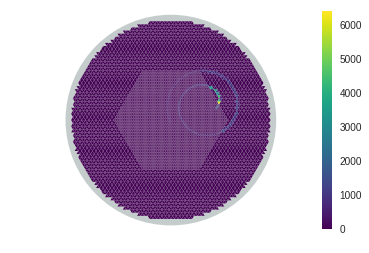

In [286]:
hits = np.zeros(10240)
for k, v in evtClean.items():
    #if hitmask[k]:
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

#plt.savefig('/home/taylor/Documents/independent-research/event-gen/plots/p_evt_00.pdf')
#plt.savefig('/home/taylor/Documents/independent-research/event-gen/plots/BAD_evt_example.pdf')

# Adding Noise

In [287]:
#Adding keys/values to dictionary event object for missing pads
for padAddress in range(0,10240):
    if (padAddress not in evtClean):
        evtClean[padAddress] = np.zeros(512)
        evtNoise[padAddress] = np.zeros(512)
        evtGaussianNoise[padAddress] = np.zeros(512)
    else:
        print("Pad " + str(padAddress) + " already in event")

Pad 143 already in event
Pad 144 already in event
Pad 145 already in event
Pad 146 already in event
Pad 147 already in event
Pad 148 already in event
Pad 170 already in event
Pad 171 already in event
Pad 172 already in event
Pad 173 already in event
Pad 174 already in event
Pad 176 already in event
Pad 279 already in event
Pad 280 already in event
Pad 436 already in event
Pad 438 already in event
Pad 439 already in event
Pad 440 already in event
Pad 441 already in event
Pad 442 already in event
Pad 443 already in event
Pad 465 already in event
Pad 466 already in event
Pad 467 already in event
Pad 468 already in event
Pad 469 already in event
Pad 574 already in event
Pad 575 already in event
Pad 727 already in event
Pad 728 already in event
Pad 729 already in event
Pad 730 already in event
Pad 731 already in event
Pad 732 already in event
Pad 755 already in event
Pad 756 already in event
Pad 757 already in event
Pad 758 already in event
Pad 759 already in event
Pad 862 already in event


In [288]:
print(len(evtClean))
print(len(evtNoise))
print(len(evtGaussianNoise))

10240
10240
10240


In [289]:
nm = NoiseMaker(config)

In [290]:
%%capture
# (evt, depress_baseline, gaussian_noise, clip)

evtNoise = nm.add_noise(evtNoise, True, True, True)

evtNoiseNOCLIP = nm.add_noise(evtNoiseNOCLIP, True, True, False)

evtDepressNoise = nm.add_noise(evtDepressNoise, True, False, False)
evtGaussianNoise = nm.add_noise(evtGaussianNoise, False, True, False)
evtClipNoise = nm.add_noise(evtClipNoise, False, False, True)

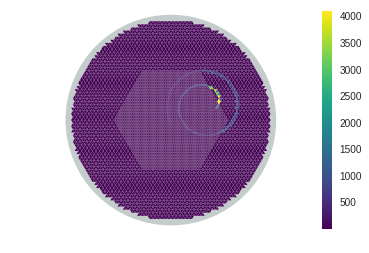

In [291]:
hits = np.zeros(10240)
for k, v in evtNoise.items():
    #if hitmask[k]:
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

#plt.savefig('/home/taylor/Documents/independent-research/event-gen/pad_plot.pdf')

# Converting simulated events to Event objects

In [292]:
pyevtClean = sim.convert_event(evtClean)
pyevtNoise = sim.convert_event(evtNoise)

pyevtNoiseNOCLIP = sim.convert_event(evtNoiseNOCLIP)

pyevtDepressNoise = sim.convert_event(evtDepressNoise)
pyevtGaussianNoise = sim.convert_event(evtGaussianNoise)
pyevtClipNoise = sim.convert_event(evtClipNoise)

In [293]:
print(pyevtClean)
print(pyevtNoise)
print(pyevtDepressNoise)
print(pyevtGaussianNoise)
print(pyevtClipNoise)

Event 0, timestamp 0.
Contains 10240 traces.
Event 0, timestamp 0.
Contains 10240 traces.
Event 0, timestamp 0.
Contains 442 traces.
Event 0, timestamp 0.
Contains 10240 traces.
Event 0, timestamp 0.
Contains 442 traces.


# Plots

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


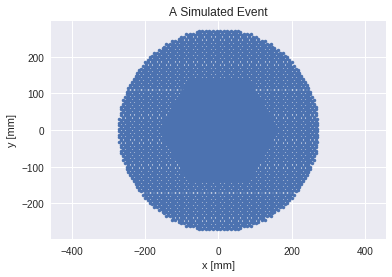

In [274]:
new_xyzs = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
plt.plot(new_xyzs[:,0], new_xyzs[:,1], '.')
plt.axis('equal')
    
plt.title('A Simulated Event')
    
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


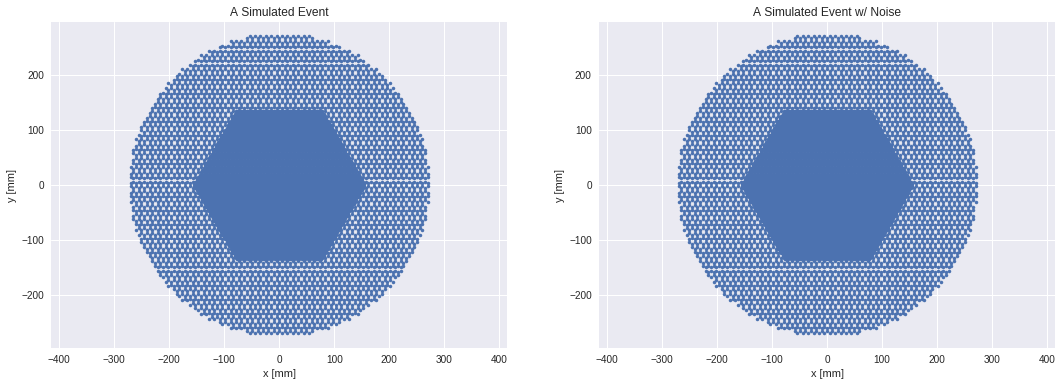

In [275]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,0], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
new_xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(new_xyzs_Noise[:,0], new_xyzs_Noise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Noise')
    
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_pxy.pdf')

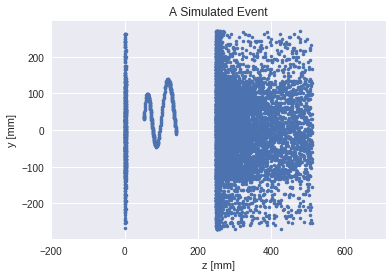

In [205]:
new_xyzs = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
plt.plot(new_xyzs[:,2], new_xyzs[:,1], '.')
plt.axis('equal')
    
plt.title('A Simulated Event')
    
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


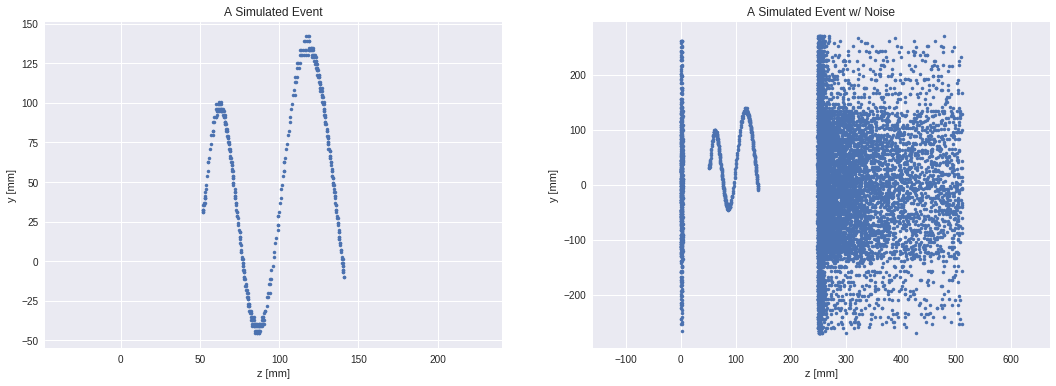

In [206]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,2], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
new_xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(new_xyzs_Noise[:,2], new_xyzs_Noise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Noise')
    
ax[1].set_xlabel('z [mm]')
ax[1].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_pzy.pdf')

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


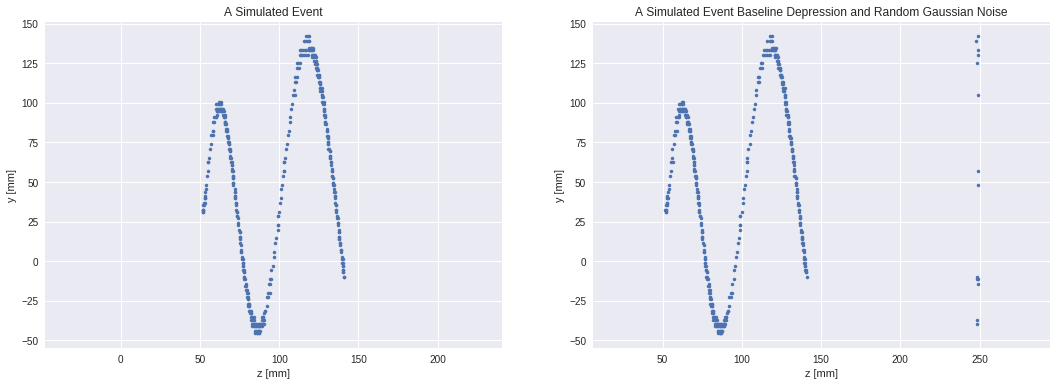

In [207]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,2], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
xyzs_NoiseNOCLIP = pyevtNoiseNOCLIP.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(xyzs_NoiseNOCLIP[:,2], xyzs_NoiseNOCLIP[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event Baseline Depression and Random Gaussian Noise')
    
ax[1].set_xlabel('z [mm]')
ax[1].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_pzy.pdf')

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


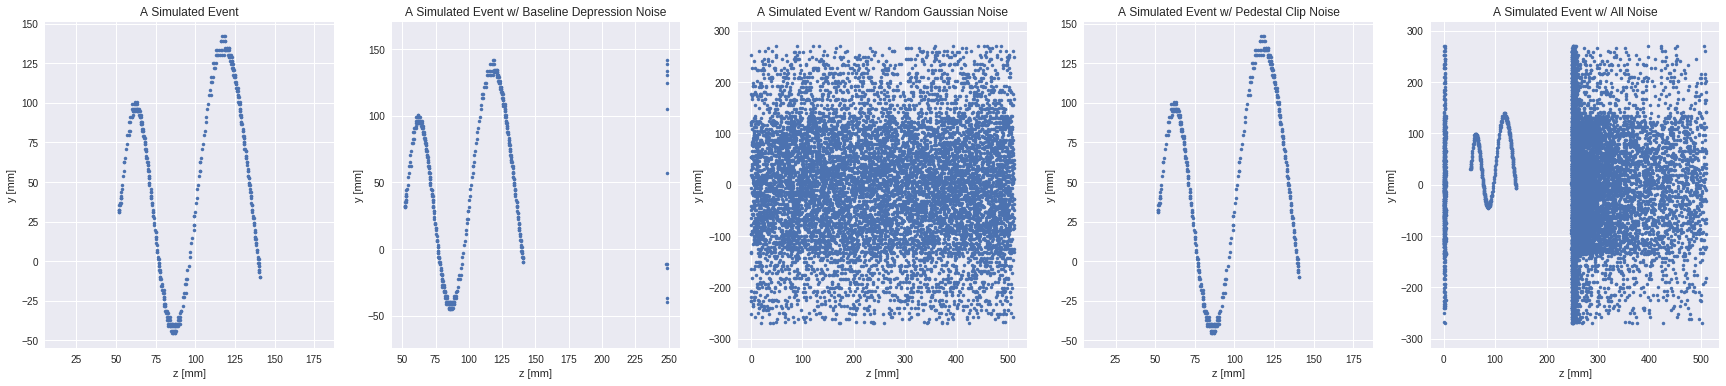

In [294]:
fig, ax = plt.subplots(1, 5, squeeze=True, figsize=(30, 6))

xyzs_clean = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(xyzs_clean[:,2], xyzs_clean[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
xyzs_DepressNoise = pyevtDepressNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(xyzs_DepressNoise[:,2], xyzs_DepressNoise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Baseline Depression Noise')
    
ax[1].set_xlabel('z [mm]')
ax[1].set_ylabel('y [mm]')

####################################################################################################################
xyzs_GaussianNoise = pyevtGaussianNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[2].plot(xyzs_GaussianNoise[:,2], xyzs_GaussianNoise[:,1], '.')
ax[2].axis('equal')
    
ax[2].set_title('A Simulated Event w/ Random Gaussian Noise')
    
ax[2].set_xlabel('z [mm]')
ax[2].set_ylabel('y [mm]')

####################################################################################################################
xyzs_ClipNoise = pyevtClipNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[3].plot(xyzs_ClipNoise[:,2], xyzs_ClipNoise[:,1], '.')
ax[3].axis('equal')
    
ax[3].set_title('A Simulated Event w/ Pedestal Clip Noise')
    
ax[3].set_xlabel('z [mm]')
ax[3].set_ylabel('y [mm]')

####################################################################################################################
xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[4].plot(xyzs_Noise[:,2], xyzs_Noise[:,1], '.')
ax[4].axis('equal')
    
ax[4].set_title('A Simulated Event w/ All Noise')
    
ax[4].set_xlabel('z [mm]')
ax[4].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/separateNoiseCompare_stDev5e-1.pdf')

(-296.94822653861917,
 296.94822653861917,
 -296.31532412317767,
 296.31532412317767)

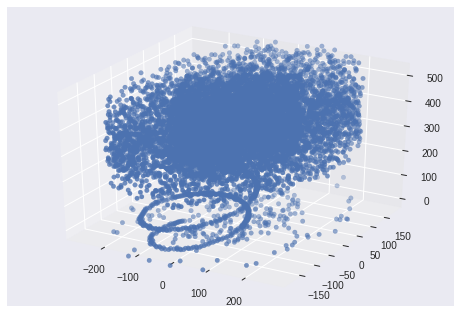

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

new_xyzs = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#print(len(new_xyzs[:,2]))
ax.scatter(new_xyzs[:,0], new_xyzs[:,1],new_xyzs[:,2])
ax.axis('equal')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_p3d_Noise.pdf')

(-296.94822653861917,
 296.94822653861917,
 -296.31532412317767,
 296.31532412317767)

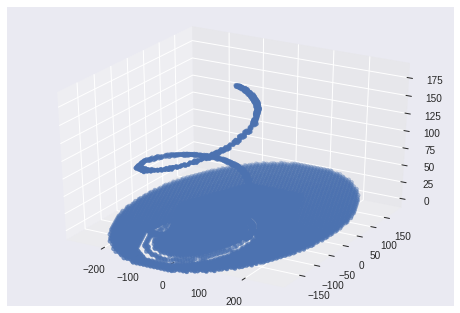

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#print(len(new_xyzs[:,2]))
ax.scatter(new_xyzs[:,0], new_xyzs[:,1],new_xyzs[:,2])
ax.axis('equal')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_p3d.pdf')

In [66]:
#fig = plt.figure()

#ax = fig.add_subplot(111, projection='3d')
#new_xyzs = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#ax.scatter(new_xyzs[:,0], new_xyzs[:,1],new_xyzs[:,2])

#new_xyzs_noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#ax.scatter(new_xyzs_noise[:,0], new_xyzs_noise[:,1],new_xyzs_noise[:,2], 
#           c = ('blue' if (new_xyzs_noise[:,0] in new_xyzs) else 'red'))

#ax.axis('equal')

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/tpcplot.py:168: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('none')


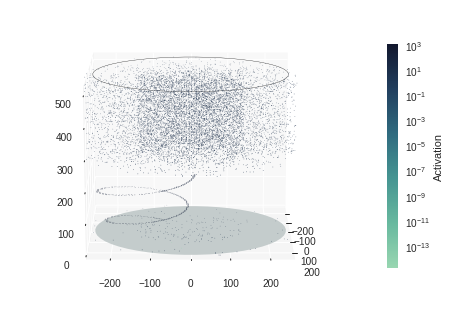

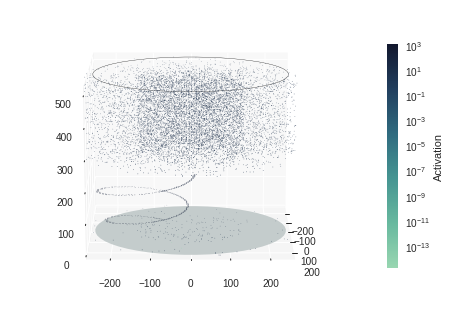

In [69]:
new_xyzs_noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

chamber_plot(new_xyzs_noise[:])
#plt.savefig('/home/taylor/Documents/independent-research/event-gen/plots/chamber_plot.pdf')

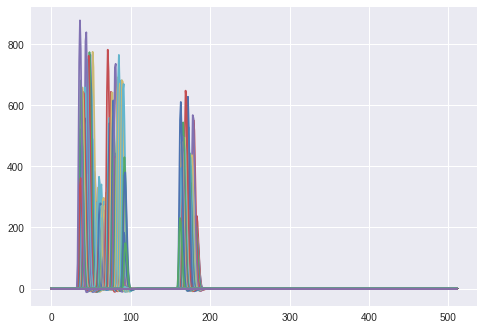

In [190]:
#for trace in pyevtClean.traces['data']:
#    plt.plot(trace)

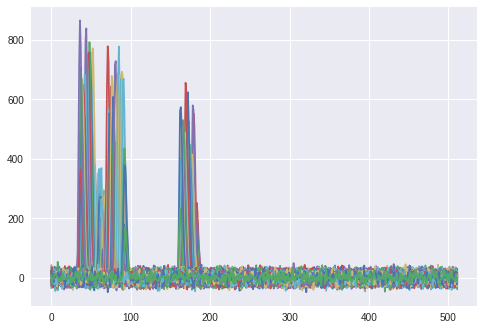

In [133]:
#for trace in pyevtGaussianNoise.traces['data']:
#    plt.plot(trace)

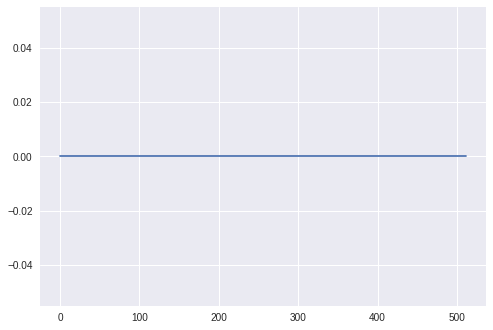

In [193]:
tr = pyevtClean.traces['data'][3776]
plt.plot(tr)


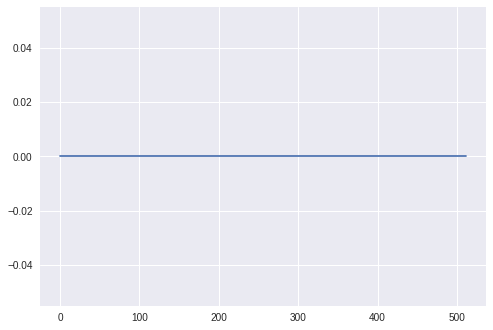

In [194]:
tr1 = pyevtGaussianNoise.traces['data'][3776]
plt.plot(tr1)
#plt.xlim(-10,100)

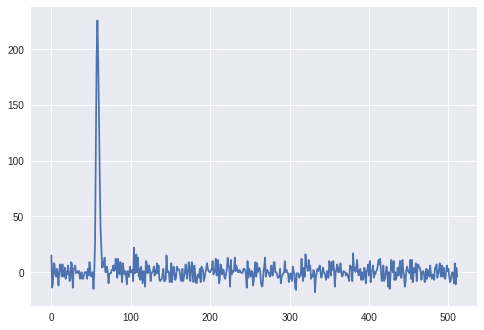

In [195]:
tr2 = pyevtGaussianNoise.traces['data'][0]
plt.plot(tr2)

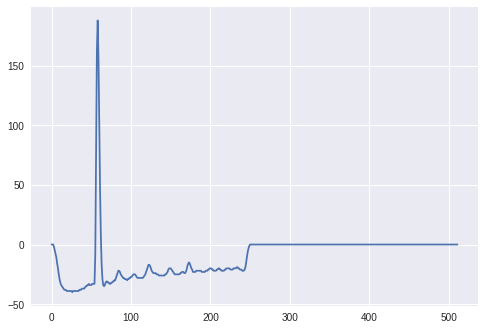

In [196]:
tr2 = pyevtDepressNoise.traces['data'][0]
plt.plot(tr2)

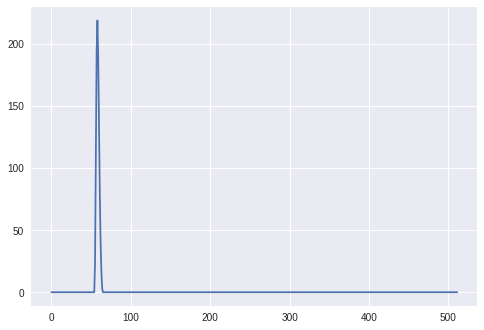

In [197]:
tr2 = pyevtClipNoise.traces['data'][0]
plt.plot(tr2)